In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import numpy as np

import torch

In [100]:
from datetime import datetime

In [3]:
import optim
import functions

In [166]:
class UCBController():
    def __init__(self, arms, c=0.5):
        self.arms = arms
        self.rewards = [[] for _ in self.arms]
        self.Ns = np.zeros(len(self.arms))
        self.c = c
        
    def sample(self):
        if (self.Ns==0).any():
            i = (self.Ns==0).argmax()
        else:
            Qs = np.array([np.array(r)[-50:].mean() for r in self.rewards])

            t = self.Ns.sum()

            explore = np.sqrt(np.log(t)/self.Ns)
            exploit = Qs

            i = np.argmax(exploit+self.c*explore)
        return i, self.arms[i]
    
    def report_reward(self, i, reward):
        self.Ns[i] += 1
        self.rewards[i].append(reward)
        if len(self.rewards[i])>50:
            self.rewards[i] = self.rewards[i][-50:]
        
def run_evolution_ucb(pop, optim_fn, n_gen, mrs, 
                      k=.5, k_elite=None, 
                      return_ucb=False, 
                      tqdm=lambda x: x):
    data = []
    fit = optim_fn(pop)
    mr = mrs[0]

    ucb = UCBController(mrs)

    # data.append((pop, fit, mr))
    for i in tqdm(range(n_gen)):
        idxs_elite, idxs_rest, idxs_cat = optim.calc_npop_idxs(fit, k=k, k_elite=k_elite)
        
        idxs_rest = idxs_rest.reshape(-1, 10)
        
        npop, nfit = [], []
        
        mrs_gen = []
        for ucb_sample_group_idx, ucb_sample_group in enumerate(idxs_rest):
            # start = datetime.now()
            mri, mr = ucb.sample()
            # end = datetime.now()
            # if i%100==0:
                # print(end-start)
            
            pop_group = pop[ucb_sample_group].clone()
            fit_group = fit[ucb_sample_group].clone()
            npop_group = pop_group+torch.randn_like(pop_group)*mr
            nfit_group = optim_fn(npop_group)
            npop.append(npop_group)
            nfit.append(nfit_group)
            
            ucb.report_reward(mri, -(nfit_group-fit_group).min())
            mrs_gen.append(mr)
            
        npop = torch.cat([pop[idxs_elite]]+npop, dim=0)
        nfit = torch.cat([fit[idxs_elite]]+nfit, dim=0)
        
        pop = npop
        fit = nfit
        
        mrs_gen = torch.tensor(mrs_gen)
        data.append((pop, fit, mrs_gen))
    # pops, fits, mrs
    
    
    res = [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]
    if return_ucb:
        return res, ucb
    else:
        return res
    
    

In [182]:
torch.manual_seed(2); np.random.seed(2)
pop = torch.randn(101, 10)*10
optim_fn = functions.ackley
mrs_in = torch.logspace(-3, 3, 10)
n_gen = 1000

In [183]:
_, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, tqdm=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [184]:
torch.manual_seed(2); np.random.seed(2)
pop = torch.randn(101, 10)*10
optim_fn = functions.ackley
mrs_in = torch.logspace(-3, 3, 10)
n_gen = 1000

In [185]:
_, fits_ucb, mrs_ucb = run_evolution_ucb(pop, optim_fn, n_gen, mrs=mrs_in, tqdm=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

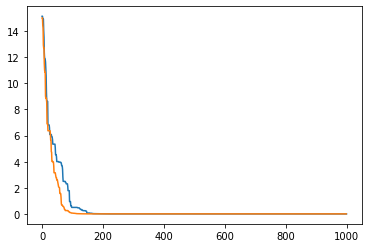

In [186]:
plt.plot(fits.min(dim=-1).values.numpy())
plt.plot(fits_ucb.min(dim=-1).values.numpy())

In [188]:
mrs_ucb.shape

torch.Size([1000, 10])

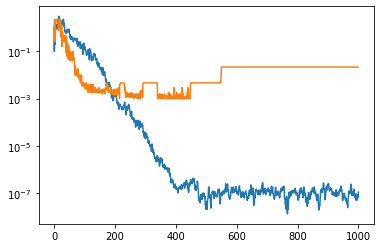

In [189]:
plt.plot(mrs[..., 0].log().mean(dim=-1).exp())
plt.plot(mrs_ucb.log().mean(dim=-1).exp())
plt.yscale('log')